##App Reviews Sentiment Analysis

dataset:https://statso.io/sentiment-analysis-case-study/

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
linkedin_data = pd.read_csv("/content/linkedin-reviews.csv")

# Display the first few rows of the dataset
print(linkedin_data.head())

                                              Review  Rating
0  Does absolutely nothing for a LinkedIn beginne...       1
1                            Force close(galaxy tab)       1
2  Slow and it tries to upload your contacts with...       1
3  Add ability to customize the profile and move ...       4
4  Good app, but it's a pain that it's not possib...       4


In [ ]:
print(linkedin_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 702 entries, 0 to 701
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  702 non-null    object
 1   Rating  702 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 11.1+ KB
None


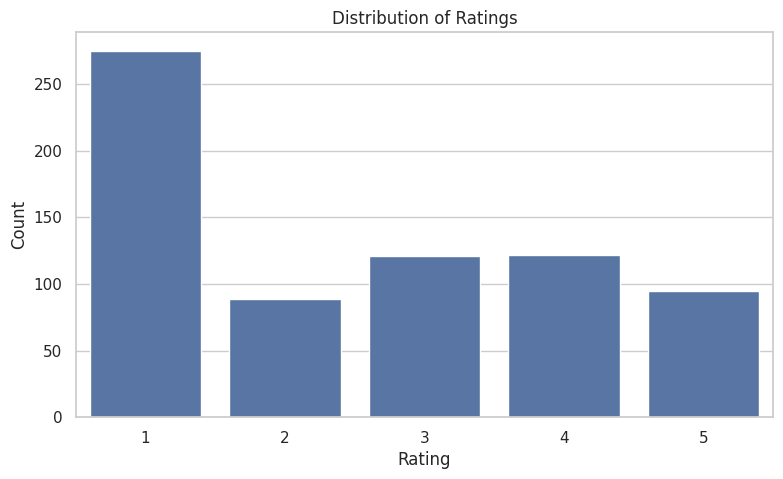

In [ ]:
# Plotting the distribution of ratings
sns.set(style="whitegrid")
plt.figure(figsize=(9, 5))
sns.countplot(data=linkedin_data, x='Rating')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

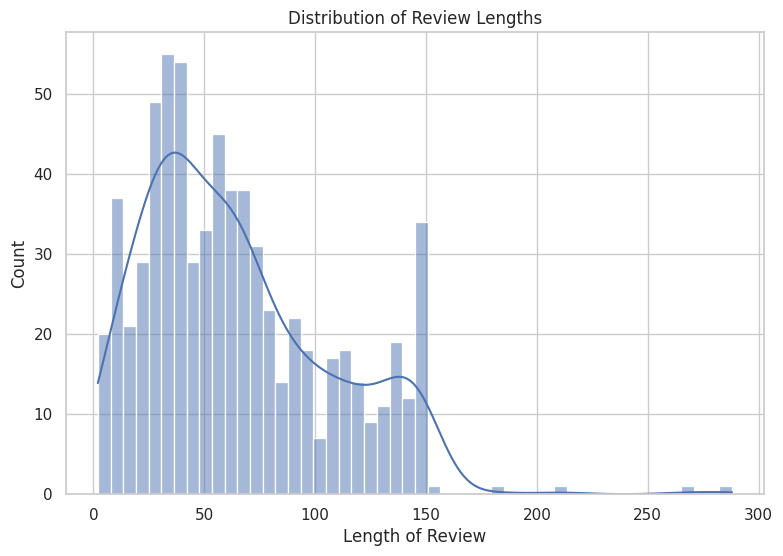

In [ ]:
# Calculating the length of each review
linkedin_data['Review Length'] = linkedin_data['Review'].apply(len)

# Plotting the distribution of review lengths
plt.figure(figsize=(9, 6))
sns.histplot(linkedin_data['Review Length'], bins=50, kde=True)
plt.title('Distribution of Review Lengths')
plt.xlabel('Length of Review')
plt.ylabel('Count')
plt.show()

**Adding Sentiment Labels in the Data**
Now, the next step is to label the data with sentiments. We can use Textblob for this task. TextBlob provides a polarity score ranging from -1 (very negative) to 1 (very positive) for a given text. We can use this score to classify each review’s sentiment as positive, neutral, or negative.

In [ ]:
from textblob import TextBlob

def textblob_sentiment_analysis(review):
    # Analyzing the sentiment of the review
    sentiment = TextBlob(review).sentiment
    # Classifying based on polarity
    if sentiment.polarity > 0.1:
        return 'Positive'
    elif sentiment.polarity < -0.1:
        return 'Negative'
    else:
        return 'Neutral'

# Applying TextBlob sentiment analysis to the reviews
linkedin_data['Sentiment'] = linkedin_data['Review'].apply(textblob_sentiment_analysis)

# Displaying the first few rows with the sentiment
print(linkedin_data.head())

                                              Review  Rating  Review Length  \
0  Does absolutely nothing for a LinkedIn beginne...       1             80   
1                            Force close(galaxy tab)       1             23   
2  Slow and it tries to upload your contacts with...       1             61   
3  Add ability to customize the profile and move ...       4             90   
4  Good app, but it's a pain that it's not possib...       4            133   

  Sentiment  
0  Negative  
1   Neutral  
2  Negative  
3   Neutral  
4  Positive  


Now that our dataset is labelled

In [ ]:
# Cross-tabulation of sentiment and ratings
sentiment_rating_table = pd.crosstab(linkedin_data['Rating'], linkedin_data['Sentiment'])
print("Sentiment vs. Rating Table:\n", sentiment_rating_table)

# Calculate correlation between Rating and sentiment polarity score
linkedin_data['Polarity'] = linkedin_data['Review'].apply(lambda x: TextBlob(x).sentiment.polarity)
correlation = linkedin_data[['Rating', 'Polarity']].corr().iloc[0, 1]
print("Correlation between Rating and Sentiment Polarity:", correlation)


Sentiment vs. Rating Table:
 Sentiment  Negative  Neutral  Positive
Rating                                
1                70      155        50
2                19       42        28
3                12       51        58
4                 5       37        80
5                 1       12        82
Correlation between Rating and Sentiment Polarity: 0.5522491353261991


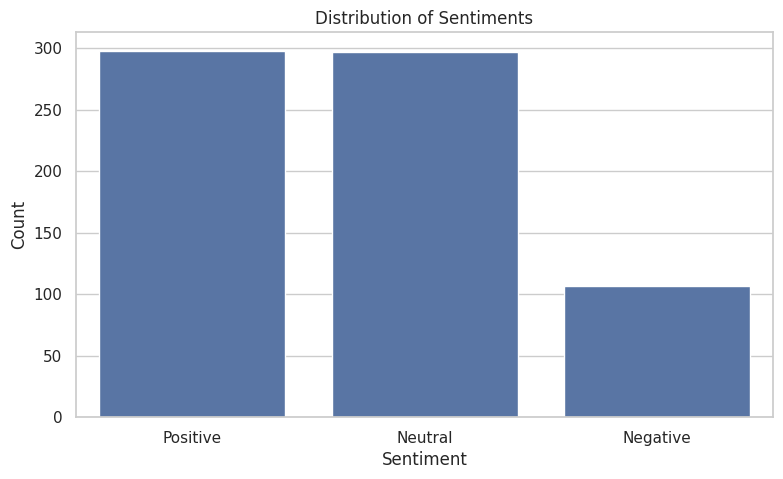

In [ ]:
# Analyzing the distribution of sentiments
sentiment_distribution = linkedin_data['Sentiment'].value_counts()

# Plotting the distribution of sentiments
plt.figure(figsize=(9, 5))
sns.barplot(x=sentiment_distribution.index, y=sentiment_distribution.values)
plt.title('Distribution of Sentiments')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

So, we can see although the app has low ratings, still the reviewers don’t use many negative words in the reviews for the app.

we’ll explore the relationship between the sentiments and the ratings. This analysis can help us understand whether there is a correlation between the sentiment of the text and the numerical rating.

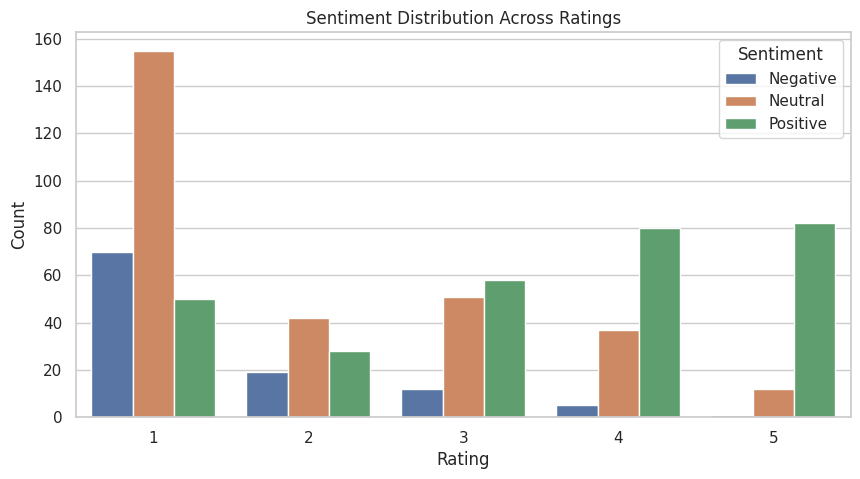

In [ ]:
plt.figure(figsize=(10, 5))
sns.countplot(data=linkedin_data, x='Rating', hue='Sentiment')
plt.title('Sentiment Distribution Across Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.legend(title='Sentiment')
plt.show()

let’s perform a text analysis to identify common words or themes within each sentiment category.

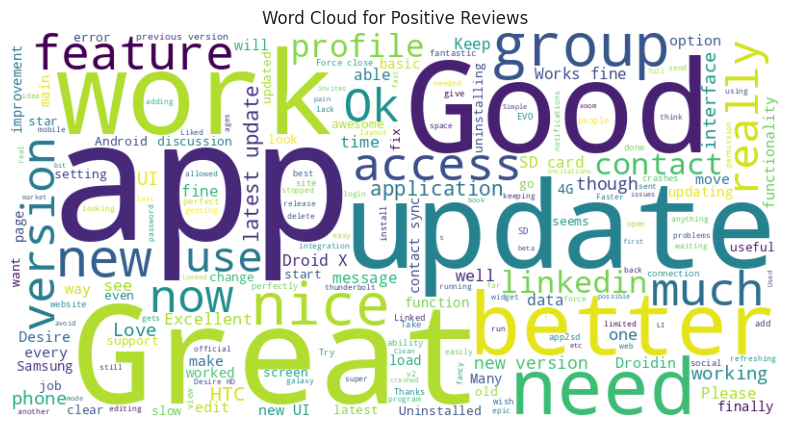

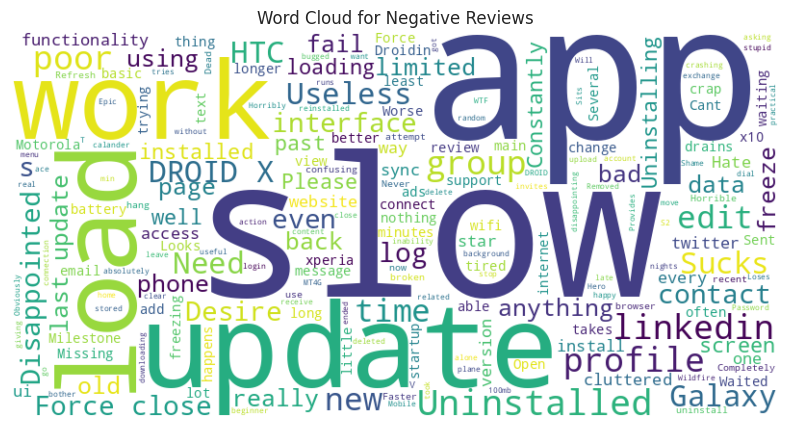

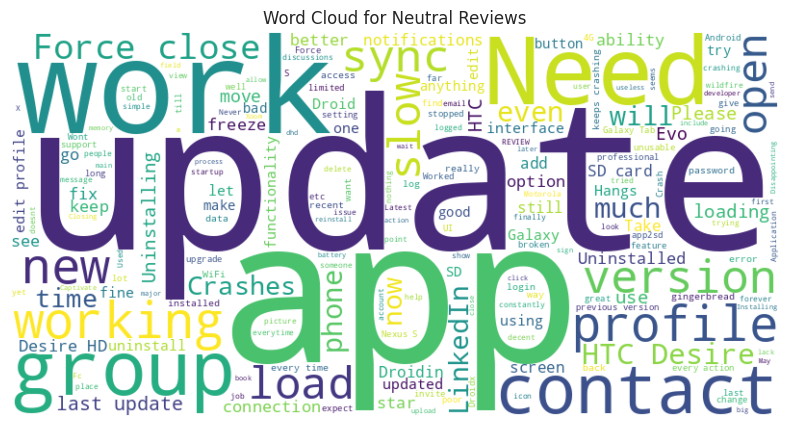

In [ ]:
from wordcloud import WordCloud

# Function to generate word cloud for each sentiment
def generate_word_cloud(sentiment):
    text = ' '.join(review for review in linkedin_data[linkedin_data['Sentiment'] == sentiment]['Review'])
    wordcloud = WordCloud(width=800, height=400, background_color ='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for {sentiment} Reviews')
    plt.axis('off')
    plt.show()

# Generating word clouds for each sentiment
for sentiment in ['Positive', 'Negative', 'Neutral']:
    generate_word_cloud(sentiment)

                                              Review  Rating Sentiment  \
0  Does absolutely nothing for a LinkedIn beginne...       1  Negative   
1                            Force close(galaxy tab)       1   Neutral   
2  Slow and it tries to upload your contacts with...       1  Negative   
3  Add ability to customize the profile and move ...       4   Neutral   
4  Good app, but it's a pain that it's not possib...       4  Positive   

     Composite_Label Final_Label  
0  Strongly Negative    Negative  
1     Mixed Negative    Negative  
2  Strongly Negative    Negative  
3     Mixed Positive    Positive  
4  Strongly Positive    Positive  
Distribution of Final Labels:
Final_Label
Negative    364
Positive    217
Neutral     121
Name: count, dtype: int64


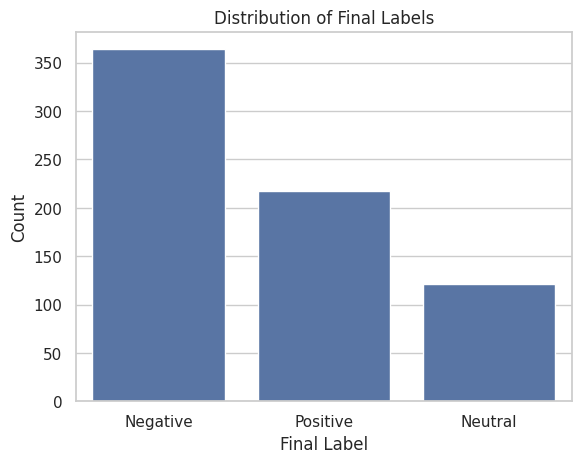

In [ ]:
def composite_label(row):
    """
    Refined rule-based logic:
    - Positive Rating (4-5) + Positive Sentiment = Strongly Positive (Positive-Positive)
    - Positive Rating (4-5) + Neutral/Negative Sentiment = Mixed Positive (Positive-Neutral)
    - Low Rating (1-2) + Negative Sentiment = Strongly Negative (Negative-Negative)
    - Low Rating (1-2) + Neutral/Positive Sentiment = Mixed Negative (Negative-Neutral)
    - Mid Rating (3) or Neutral Sentiment = Generally Neutral (Neutral-Neutral)
    """
    if row['Rating'] >= 4 and row['Sentiment'] == 'Positive':
        return 'Strongly Positive'
    elif row['Rating'] >= 4 and row['Sentiment'] in ['Neutral', 'Negative']:
        return 'Mixed Positive'
    elif row['Rating'] <= 2 and row['Sentiment'] == 'Negative':
        return 'Strongly Negative'
    elif row['Rating'] <= 2 and row['Sentiment'] in ['Neutral', 'Positive']:
        return 'Mixed Negative'
    else:
        return 'Neutral'

linkedin_data['Composite_Label'] = linkedin_data.apply(composite_label, axis=1)

# Step 3: Simplify into two main categories based on final analysis needs
def final_label(composite_label):
    if composite_label in ['Strongly Positive', 'Mixed Positive']:
        return 'Positive'
    elif composite_label == 'Neutral':
        return 'Neutral'
    else:
        return 'Negative'

linkedin_data['Final_Label'] = linkedin_data['Composite_Label'].apply(final_label)

# Display the first few rows with labels
print(linkedin_data[['Review', 'Rating', 'Sentiment', 'Composite_Label', 'Final_Label']].head())

# Step 4: Analyze distribution of final labels
label_counts = linkedin_data['Final_Label'].value_counts()
print("Distribution of Final Labels:")
print(label_counts)

# Optional: Visualize the final label distribution
sns.countplot(data=linkedin_data, x='Final_Label')
plt.title('Distribution of Final Labels')
plt.xlabel('Final Label')
plt.ylabel('Count')
plt.show()

Conclusion:
The LinkedIn app’s relatively low overall rating does not always reflect strong negativity in user language. Instead, many users seem to have mixed or indifferent opinions, appreciating certain features while expressing dissatisfaction with others. The sentiment analysis and word cloud findings suggest that LinkedIn could benefit from targeted improvements in key areas such as user interface, technical performance, and customer support. Addressing these specific issues could improve overall satisfaction, potentially increasing the proportion of Positive feedback in future reviews.
In summary, this analysis underscores the value of combining quantitative and qualitative insights to guide product enhancements. By addressing the recurring issues highlighted in negative reviews and building on its strengths in networking and job-seeking, LinkedIn can improve user satisfaction, potentially increase the proportion of positive sentiment in future feedback, and ultimately boost its overall ratings.
